<a href="https://colab.research.google.com/github/themathedges/3YP-Standalone-Kennington/blob/main/Ravi/Final_notebooks/Kennington_Profile_DSR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Profile Demand Side Response

**Goal:**
- To take the load profile data and make the required adjustments to simulate demand side response

## Import Data

0. Import the modules

In [1]:
import numpy as np
import pandas as pd
import datetime
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

In [2]:
# Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Import the data

In [3]:
load_profile = pd.read_csv('/content/drive/MyDrive/3YP/data/ken_dom_annual_demand_per_household.csv')

In [4]:
# import data
# load_profile = pd.read_csv("../data/load_example.csv", usecols=[1]).values
#load_profile = pd.read_csv("https://bitbucket.org/scotwheeler/oxemf_3yp/raw/5d950da31a156418c8abfa1dd86668688715e98e/data/load_example.csv", usecols=[1]).values

In [5]:
np.shape(load_profile)

(17520, 2)

In [6]:
# to process the data, it really ought to be a in a DataFrame with a date column attached to it
# we need to create a list of dates and times to span the whole year in 30 minute periods
year = '2018'
dti = pd.date_range(year + '-01-01', periods=17520, freq="0.5H")

# note that this list of times starts at Jan 1st 00:00:00. If we want to start at 00:30:00, then do the following:
# 1. Change the periods to 17521
# 2. dti = dti[1:] to remove the 00:00:00 entry

In [7]:
load_profile['Power (kW)'].values

array([0.3801014 , 0.32251028, 0.2879556 , ..., 0.67957522, 0.56439298,
       0.47224719])

In [8]:
# put all this data into a dataframe
load_profile_df = pd.DataFrame(dti, columns=['Date_Time'])
load_profile_df['Power (kW)'] = load_profile['Power (kW)'].values
load_profile_df['Date'] = [d.date() for d in load_profile_df['Date_Time']]      # separating it into separate date and time columns to make it easier to form a mask later on
load_profile_df['Time'] = [d.time() for d in load_profile_df['Date_Time']]

In [9]:
load_profile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date_Time   17520 non-null  datetime64[ns]
 1   Power (kW)  17520 non-null  float64       
 2   Date        17520 non-null  object        
 3   Time        17520 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 547.6+ KB


2. Split into Seasonal DataFrames

In [10]:
# Define the start and end dates for each of the seasons and then define the masks
# format of mask: YYYY-MM-DD

# winter
winter_pt_1_start = pd.to_datetime(year + '-01-01')
winter_pt_1_end = pd.to_datetime(year + '-02-28')
winter_pt_2_start = pd.to_datetime(year + '-12-01')
winter_pt_2_end = pd.to_datetime(year + '-12-31')

winter_pt1_mask = (load_profile_df['Date_Time'] >= winter_pt_1_start) & (load_profile_df['Date_Time'] <= winter_pt_1_end)
winter_pt2_mask = (load_profile_df['Date_Time'] >= winter_pt_2_start) & (load_profile_df['Date_Time'] <= winter_pt_2_end)

# spring
spring_start = pd.to_datetime(year + '-03-01')
spring_end = pd.to_datetime(year + '-05-31')

spring_mask = (load_profile_df['Date_Time'] >= spring_start) & (load_profile_df['Date_Time'] <= spring_end)

# summer
summer_start = pd.to_datetime(year + '-06-01')
summer_end = pd.to_datetime(year + '-08-31')

summer_mask = (load_profile_df['Date_Time'] >= summer_start) & (load_profile_df['Date_Time'] <= summer_end)

# autumn
autumn_start = pd.to_datetime(year + '-09-01')
autumn_end = pd.to_datetime(year + '-11-30')

autumn_mask = (load_profile_df['Date_Time'] >= autumn_start) & (load_profile_df['Date_Time'] <= autumn_end)

In [11]:
# extract each of the dataframes

# winter_pt_1 
winter1_df = load_profile_df.loc[winter_pt1_mask]

# winter_pt_2 
winter2_df = load_profile_df.loc[winter_pt2_mask]

winter_combined_df = pd.concat([winter1_df, winter2_df])    # combine the two DataFrames from winter
winter_combined_df.reset_index(inplace = True, drop = True)

# spring
spring_df = load_profile_df.loc[spring_mask]

# summer
summer_df = load_profile_df.loc[summer_mask]

# autumn
autumn_df = load_profile_df.loc[autumn_mask]

In [12]:
len(winter1_df), len(winter2_df), len(spring_df), len(summer_df), len(autumn_df)

(2785, 1441, 4369, 4369, 4321)

3.  Define the functions to edit the demand profile

3.1 Import the data to edit the demand profile

In [13]:
dsr_edit_data = pd.read_csv('/content/drive/MyDrive/3YP/data/demand_response_final/3yp_dsr_data_reduct_shift.csv') #_test.csv
dsr_edit_data['autumn_bottom_25_low'] = pd.to_numeric(dsr_edit_data['autumn_bottom_25_low'], errors='coerce')
dsr_edit_data = dsr_edit_data.fillna(0)[:-2]

In [14]:
dsr_edit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   30 Minute Time Period         48 non-null     object 
 1   winter_top_25_low             48 non-null     float64
 2   winter_top_25_medium_low      48 non-null     float64
 3   winter_top_25_medium_high     48 non-null     float64
 4   winter_top_25_high            48 non-null     float64
 5   winter_bottom_25_low          48 non-null     float64
 6   winter_bottom_25_medium_low   48 non-null     float64
 7   winter_bottom_25_medium_high  48 non-null     float64
 8   winter_bottom_25_high         48 non-null     float64
 9   spring_top_25_low             48 non-null     float64
 10  spring_top_25_medium_low      48 non-null     float64
 11  spring_top_25_medium_high     48 non-null     float64
 12  spring_top_25_high            48 non-null     float64
 13  spring_

## Write functions to edit data

**Purpose:** 
- Takes the demand side response data and combines the columns to form one column for each season, engagement level
- Has the option to include wet appliances shift & reduction
- Has the option to include cold appliance reduction

In [15]:
def dsr_season_combine(dsr_data, wet_appliance_bool = False, cold_appliance_bool = False):

  # set wet and cold appliance booleans
  if wet_appliance_bool == True:
    wet_appliance_factor = 1
  else:
    wet_appliance_factor = 0
  
  if cold_appliance_bool == True:
    cold_appliance_factor = 1
  else:
    cold_appliance_factor = 0
  
  # factors
  cold_appliance_reduction = 0.9 * dsr_data['cold_reduction_kW']
  wet_appliance_reduction = dsr_data['wet_appliance_reduction']+ (0.8 * dsr_data['wet_appliance_shift'])  

  # reduction
  cold_reduction = cold_appliance_reduction * cold_appliance_factor
  wet_reduction = wet_appliance_reduction * wet_appliance_factor

  # We will do this individually just in case any seasons want to use any different interpolation values
  # spring
  dsr_data['spring_top_25'] = dsr_data['spring_top_25_low'] + dsr_data['spring_top_25_high'] + cold_reduction + wet_reduction
  dsr_data['spring_bottom_25'] = dsr_data['spring_bottom_25_low'] + dsr_data['spring_bottom_25_high']

  # summer
  dsr_data['summer_top_25'] = dsr_data['summer_top_25_low'] + dsr_data['summer_top_25_high'] + cold_reduction + wet_reduction
  dsr_data['summer_bottom_25'] = dsr_data['summer_bottom_25_low'] + dsr_data['summer_bottom_25_high']

  # autumn
  dsr_data['autumn_top_25'] = dsr_data['autumn_top_25_low'] + dsr_data['autumn_top_25_high'] + cold_reduction + wet_reduction
  dsr_data['autumn_bottom_25'] = dsr_data['autumn_bottom_25_low'] + dsr_data['autumn_bottom_25_high']
 
  # winter
  dsr_data['winter_top_25'] = dsr_data['winter_top_25_low'] + dsr_data['winter_top_25_high'] + cold_reduction + wet_reduction
  dsr_data['winter_bottom_25'] = dsr_data['winter_bottom_25_low'] + dsr_data['winter_bottom_25_high']
 
  dsr_data['spring_top_25'] = dsr_data['spring_top_25']                   
  dsr_data['spring_bottom_25'] = dsr_data['spring_bottom_25']              
  dsr_data['summer_top_25'] = dsr_data['summer_top_25'] 
  dsr_data['summer_bottom_25'] = dsr_data['summer_bottom_25'] 
  dsr_data['autumn_top_25'] = dsr_data['autumn_top_25'] 
  dsr_data['autumn_bottom_25'] = dsr_data['autumn_bottom_25'] 
  dsr_data['winter_top_25'] = dsr_data['winter_top_25'] 
  dsr_data['winter_bottom_25'] = dsr_data['winter_bottom_25'] 

  return dsr_data

In [16]:
# return a Data Frame which has 
dsr_edit_data = dsr_season_combine(dsr_edit_data, True, True)

Define a function that edits the data and takes the inputs:
- Season
- Level of Performer

In [18]:
''' 
inputs: 
- load_df                                                                       : (DataFrame)
- dsr_response_df     - contains the response data (kW)                         : (DataFrame)

- season              - what season is this dataframe                           : (string)
- engagement_level    - are they a 'top' OR 'bottom' performer                  : (string)

output:
- a new DataFrame
'''

def dsr_seaon_data_editor(load_df, dsr_edit_df, season, engagement_level):
  
  # 0. Make a copy of the load_df
  new_df = load_df.copy()
  new_df['Ideal_demand_kW'] = new_df['Power (kW)']    # ideal demand is the proposed demand
  
  # 1. Form the string of columns to extract
  # string is of the form [SEASON]_[ENGAGEMENT]_25
  core_column_string = str(season)+'_'+str(engagement_level)+"_25"

  # 2. Extract those column values
  dsr_response_values = dsr_edit_df[core_column_string].values

  # 3. Combine them with the current dataframe
  for i in range(len(load_df['Time'].unique())):
    new_df.loc[new_df['Time'] == load_df['Time'].unique()[i], 'Ideal_demand_kW'] += dsr_response_values[i]

  # 5. Return the new dataframe
  return new_df

## Edit the Summer data

In [19]:
#shortened_summer_df['Ideal_demand_kW'] = shortened_summer_df['Power (kW)'] + dsr_edit_data['summer_top_25'].values
#shortened_summer_df['Ideal_demand_kW_bottom'] = shortened_summer_df['Power (kW)'] + dsr_edit_data['summer_bottom_25'].values

In [20]:
# editing the summer data with the top_25 and bottom_25 response data
new_summer_df_top = dsr_seaon_data_editor(summer_df, dsr_edit_data, season='summer', engagement_level='top')
shortened_summer_df_top = new_summer_df_top[:48]

In [21]:
# editing the summer data with the top_25 and bottom_25 response data
new_summer_df_bottom = dsr_seaon_data_editor(summer_df, dsr_edit_data, season='summer', engagement_level='bottom')
shortened_summer_df_bottom = new_summer_df_bottom[:48]

In [22]:
# define the start and end points for our plot
summer_start = 0
summer_end = 48

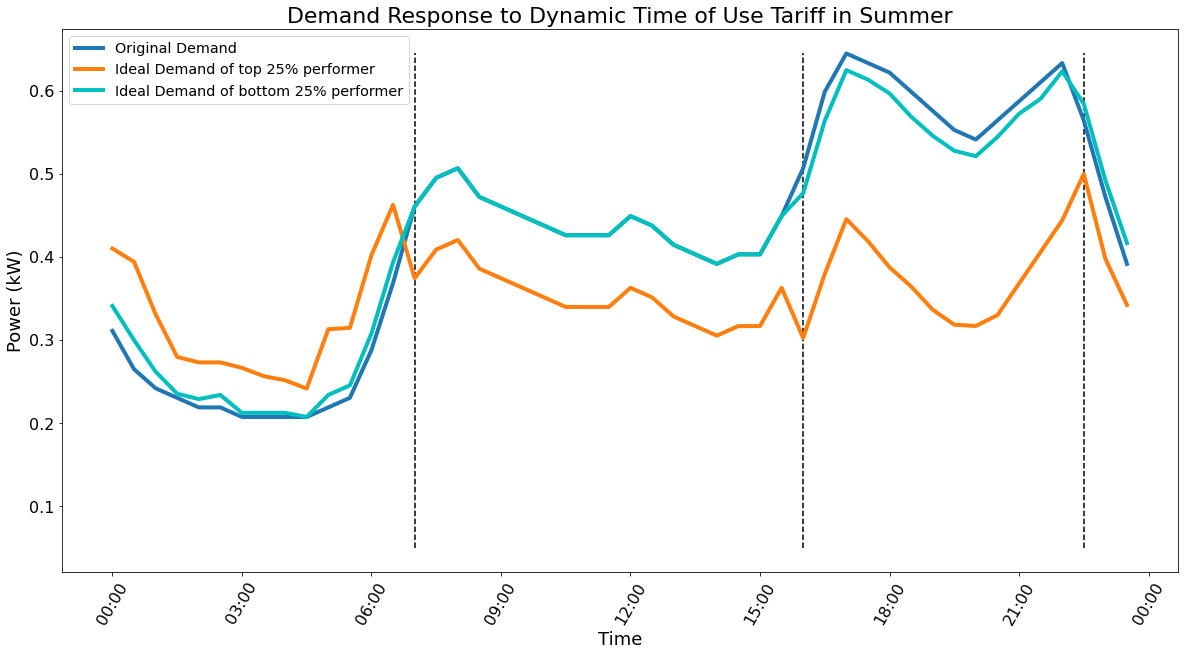

In [23]:
fig, ax = plt.subplots(figsize = (20, 10)) #plt.figure(figsize=(20,10))
ax.plot(shortened_summer_df_top['Date_Time'], new_summer_df_top['Power (kW)'][summer_start:summer_end], label='Original Demand', linewidth=4)
ax.plot(shortened_summer_df_top['Date_Time'], new_summer_df_top['Ideal_demand_kW'][summer_start:summer_end], label='Ideal Demand of top 25% performer', linewidth=4)
ax.plot(shortened_summer_df_bottom['Date_Time'], new_summer_df_bottom['Ideal_demand_kW'][summer_start:summer_end], color = 'c', label='Ideal Demand of bottom 25% performer', linewidth=4)
ax.vlines(shortened_summer_df_top['Date_Time'].values[14], 0.05, max(shortened_summer_df_top['Power (kW)']), colors = 'k', linestyles='--')
ax.vlines(shortened_summer_df_top['Date_Time'].values[32], 0.05, max(shortened_summer_df_top['Power (kW)']), colors = 'k', linestyles='--')
ax.vlines(shortened_summer_df_top['Date_Time'].values[45], 0.05, max(shortened_summer_df_top['Power (kW)']), colors = 'k', linestyles='--')
ax.set_title('Demand Response to Dynamic Time of Use Tariff in Summer', fontsize=22)
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Power (kW)', fontsize=18)
myFmt = mdates.DateFormatter('%H:%M')   # format the times into Hour:Minute format
ax.xaxis.set_major_formatter(myFmt)   # apply HH:MM format to the x axis data
ax.legend(loc = 0, fontsize='x-large')
#ax.set_xticks(rotation = 70, fontsize=16)
ax.tick_params(axis='x', labelrotation = 60, labelsize=16)
ax.tick_params(axis='y', labelsize=16)          #labelrotation = 45)
#ax.set_yticks(fontsize=16)

## Editing the Spring Data

In [24]:
# editing the spring data with the top_25 and bottom_25 response data
new_spring_df_top = dsr_seaon_data_editor(spring_df, dsr_edit_data, season='spring', engagement_level='top')
#shortened_spring_df_top = new_spring_df_top[:48]

In [25]:
# editing the spring data with the top_25 and bottom_25 response data
new_spring_df_bottom = dsr_seaon_data_editor(spring_df, dsr_edit_data, season='spring', engagement_level='bottom')
#shortened_spring_df_bottom = new_spring_df_bottom[:48]

In [26]:
# define the start and end points for our plot
spring_start = 0
spring_end = 48

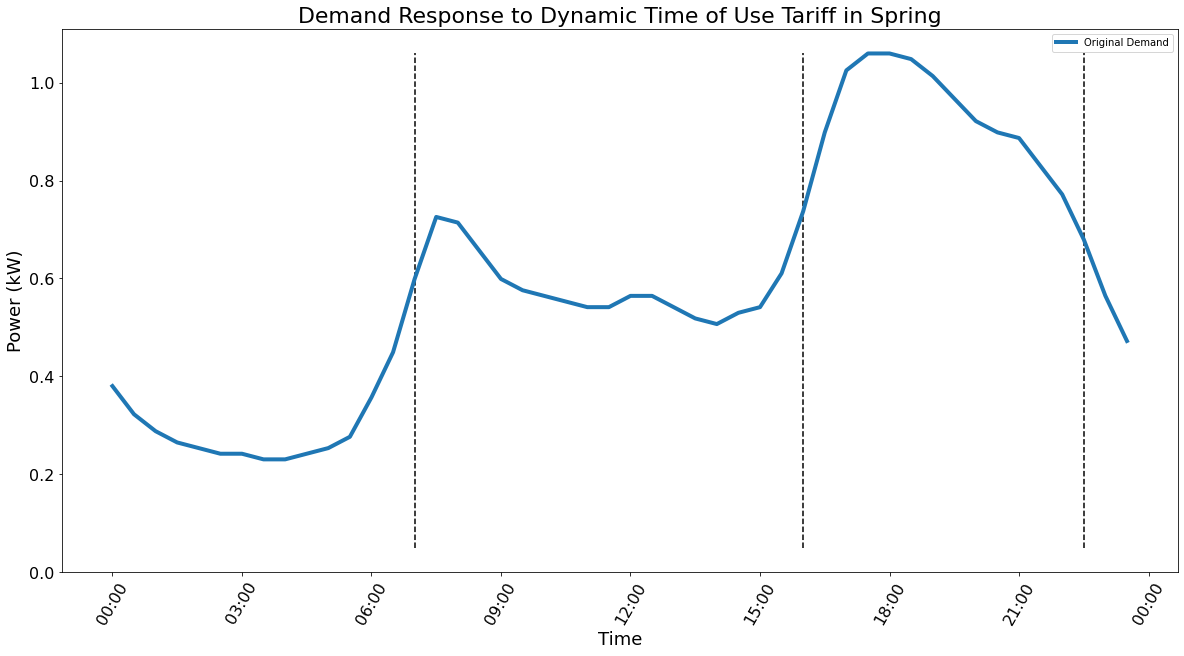

In [27]:
fig, ax = plt.subplots(figsize = (20, 10)) #plt.figure(figsize=(20,10))
ax.plot(new_spring_df_top['Date_Time'][spring_start:spring_end], new_spring_df_top['Power (kW)'][spring_start:spring_end], label='Original Demand', linewidth=4)
#ax.plot(new_spring_df_top['Date_Time'][spring_start:spring_end], new_spring_df_top['Ideal_demand_kW'][summer_start:summer_end], label='Ideal Demand of top 25% performer', linewidth=4)
#ax.plot(new_spring_df_bottom['Date_Time'][spring_start:spring_end], new_spring_df_bottom['Ideal_demand_kW'][spring_start:spring_end], color = 'c', label='Ideal Demand of bottom 25% performer', linewidth=4)
ax.vlines(new_spring_df_top['Date_Time'].values[14], 0.05, max(new_spring_df_top['Power (kW)'][spring_start:spring_end]), colors = 'k', linestyles='--')
ax.vlines(new_spring_df_top['Date_Time'].values[32], 0.05, max(new_spring_df_top['Power (kW)'][spring_start:spring_end]), colors = 'k', linestyles='--')
ax.vlines(new_spring_df_top['Date_Time'].values[45], 0.05, max(new_spring_df_top['Power (kW)'][spring_start:spring_end]), colors = 'k', linestyles='--')
ax.set_title('Demand Response to Dynamic Time of Use Tariff in Spring', fontsize=22)
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Power (kW)', fontsize=18)
myFmt = mdates.DateFormatter('%H:%M')   # format the times into Hour:Minute format
ax.xaxis.set_major_formatter(myFmt)   # apply HH:MM format to the x axis data
ax.legend(loc = 0, fontsize='medium')
#ax.set_xticks(rotation = 70, fontsize=16)
ax.tick_params(axis='x', labelrotation = 60, labelsize=16)
ax.tick_params(axis='y', labelsize=16)          #labelrotation = 45)
#ax.set_yticks(fontsize=16)

## Editing the Autumn data

In [28]:
# editing the autumn data with the top_25 and bottom_25 response data
new_autumn_df_top = dsr_seaon_data_editor(autumn_df, dsr_edit_data, season='autumn', engagement_level='top')
new_autumn_df_bottom = dsr_seaon_data_editor(autumn_df, dsr_edit_data, season='autumn', engagement_level='bottom')

In [29]:
# define the start and end points for our plot
autumn_start = 0
autumn_end = 48

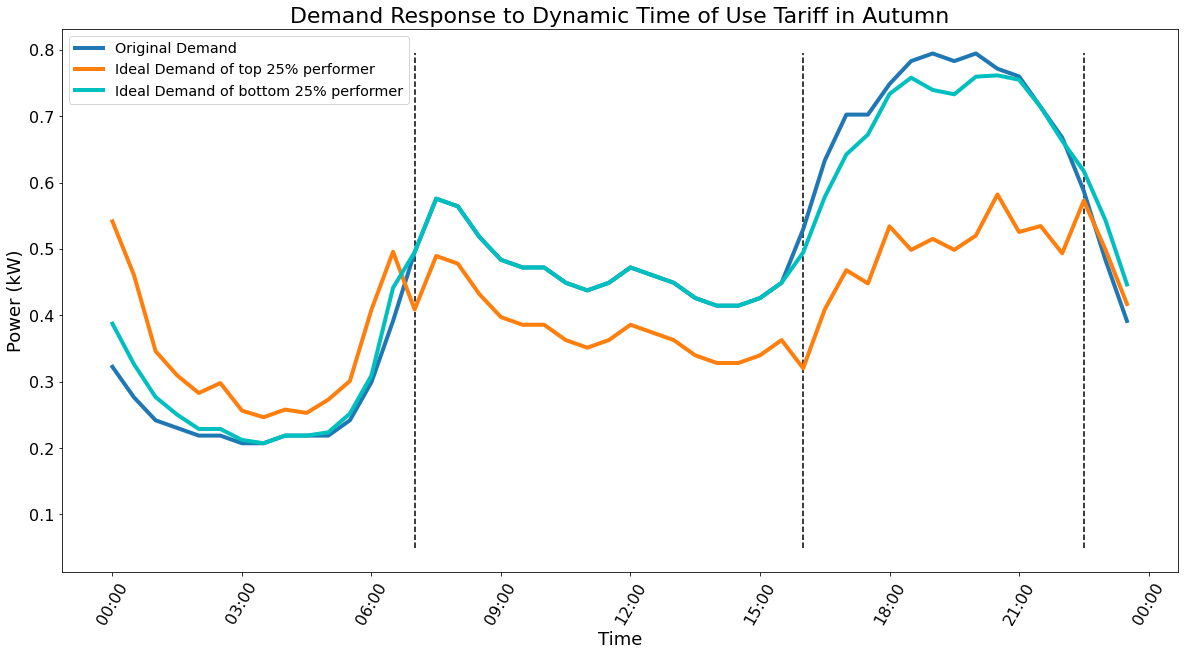

In [30]:
fig, ax = plt.subplots(figsize = (20, 10)) #plt.figure(figsize=(20,10))
ax.plot(new_autumn_df_top['Date_Time'][autumn_start:autumn_end], new_autumn_df_top['Power (kW)'][autumn_start:autumn_end], label='Original Demand', linewidth=4)
ax.plot(new_autumn_df_top['Date_Time'][autumn_start:autumn_end], new_autumn_df_top['Ideal_demand_kW'][autumn_start:autumn_end], label='Ideal Demand of top 25% performer', linewidth=4)
ax.plot(new_autumn_df_bottom['Date_Time'][autumn_start:autumn_end], new_autumn_df_bottom['Ideal_demand_kW'][autumn_start:autumn_end], color = 'c', label='Ideal Demand of bottom 25% performer', linewidth=4)
ax.vlines(new_autumn_df_top['Date_Time'].values[14], 0.05, max(new_autumn_df_top['Power (kW)'][autumn_start:autumn_end]), colors = 'k', linestyles='--')
ax.vlines(new_autumn_df_top['Date_Time'].values[32], 0.05, max(new_autumn_df_top['Power (kW)'][autumn_start:autumn_end]), colors = 'k', linestyles='--')
ax.vlines(new_autumn_df_top['Date_Time'].values[45], 0.05, max(new_autumn_df_top['Power (kW)'][autumn_start:autumn_end]), colors = 'k', linestyles='--')
ax.set_title('Demand Response to Dynamic Time of Use Tariff in Autumn', fontsize=22)
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Power (kW)', fontsize=18)
myFmt = mdates.DateFormatter('%H:%M')           # format the times into Hour:Minute format
ax.xaxis.set_major_formatter(myFmt)             # apply HH:MM format to the x axis data
ax.legend(loc = 0, fontsize='x-large')
ax.tick_params(axis='x', labelrotation = 60, labelsize=16)
ax.tick_params(axis='y', labelsize=16)          #labelrotation = 45)
#ax.set_yticks(fontsize=16)

## Editing the Winter Data

In [31]:
# editing the winter data with the top_25 and bottom_25 response data
new_winter1_df_top = dsr_seaon_data_editor(winter1_df, dsr_edit_data, season='winter', engagement_level='top')
new_winter1_df_bottom = dsr_seaon_data_editor(winter1_df, dsr_edit_data, season='winter', engagement_level='bottom')

# editing the winter data with the top_25 and bottom_25 response data
new_winter2_df_top = dsr_seaon_data_editor(winter2_df, dsr_edit_data, season='winter', engagement_level='top')
new_winter2_df_bottom = dsr_seaon_data_editor(winter2_df, dsr_edit_data, season='winter', engagement_level='bottom')

## Concatenating all the data back together again

In [32]:
# concatenating the top and bottom DataFrames
demand_response_df_top = pd.concat([new_winter1_df_top, new_spring_df_top, new_summer_df_top, new_autumn_df_top, new_winter2_df_top])
demand_response_df_bottom = pd.concat([new_winter1_df_bottom, new_spring_df_bottom, new_summer_df_bottom, new_autumn_df_bottom, new_winter2_df_bottom])

In [33]:
sum(demand_response_df_top['Ideal_demand_kW'])*0.5, sum(demand_response_df_top['Power (kW)']) * 0.5

(3742.005888717889, 4452.870574292918)

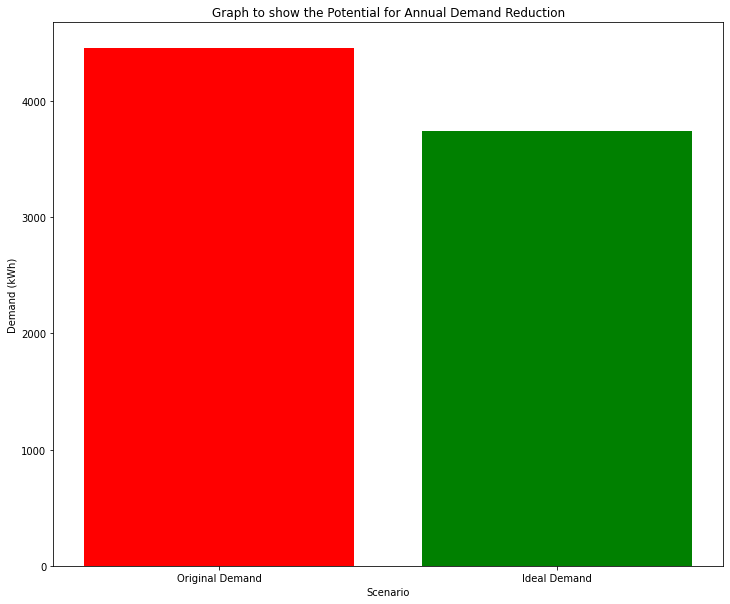

In [34]:
import matplotlib

# plot the bar chart
plt.figure(figsize=(12, 10))
plt.bar(['Original Demand', 'Ideal Demand'], [sum(demand_response_df_top['Power (kW)']) * 0.5, sum(demand_response_df_top['Ideal_demand_kW'])*0.5], color=['red', 'green'])
plt.title('Graph to show the Potential for Annual Demand Reduction')
plt.xlabel('Scenario')
plt.ylabel('Demand (kWh)')
plt.show()

#plt.text(v, i, " "+str(v), color='blue', va='center', fontweight='bold')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

## Calculating the cost savings of joining the scheme

In [35]:
# create a copy of the Data Frame
cost_df = demand_response_df_top.copy()

In [36]:
import datetime

# define the start and end times for each price band
low_price_start_time = datetime.time(22, 30) 
low_price_end_time = datetime.time(7, 30)
high_price_start_time = datetime.time(16, 30)

In [37]:
# set the mean price levels
low_price_level = 0.08
medium_price_level = 0.12
high_price_level = 0.19

In [38]:
# do the price calculation

# convert the baseline levels to kWh
cost_df['Baseline_kWh'] = cost_df['Power (kW)'] * 0.5
cost_df['Ideal_demand_kWh'] = cost_df['Ideal_demand_kW'] * 0.5    # convert ideal column

# insert a new column
cost_df['Response_cost'] = cost_df['Power (kW)']
cost_df['Original_cost'] = cost_df['Power (kW)']

# Original Price without Shifting
# low price period
cost_df.loc[((cost_df['Time'] >= low_price_start_time) | (cost_df['Time'] < low_price_end_time)), 'Original_cost'] = cost_df.loc[((cost_df['Time'] >= low_price_start_time) | (cost_df['Time'] < low_price_end_time)), 'Baseline_kWh'] * low_price_level

# medium price period
cost_df.loc[((cost_df['Time'] >= low_price_end_time) & (cost_df['Time'] < high_price_start_time)), 'Original_cost'] = cost_df.loc[((cost_df['Time'] >= low_price_end_time) & (cost_df['Time'] < high_price_start_time)), 'Baseline_kWh'] * medium_price_level

# high price period
cost_df.loc[((cost_df['Time'] >= high_price_start_time) & (cost_df['Time'] < low_price_start_time)), 'Original_cost'] = cost_df.loc[((cost_df['Time'] >= high_price_start_time) & (cost_df['Time'] < low_price_start_time)), 'Baseline_kWh'] * high_price_level


# Price after DSR
# low price period
cost_df.loc[((cost_df['Time'] >= low_price_start_time) | (cost_df['Time'] < low_price_end_time)), 'Response_cost'] = cost_df.loc[((cost_df['Time'] >= low_price_start_time) | (cost_df['Time'] < low_price_end_time)), 'Ideal_demand_kWh'] * low_price_level

# medium price period
cost_df.loc[((cost_df['Time'] >= low_price_end_time) & (cost_df['Time'] < high_price_start_time)), 'Response_cost'] = cost_df.loc[((cost_df['Time'] >= low_price_end_time) & (cost_df['Time'] < high_price_start_time)), 'Ideal_demand_kWh'] * medium_price_level

# high price period
cost_df.loc[((cost_df['Time'] >= high_price_start_time) & (cost_df['Time'] < low_price_start_time)), 'Response_cost'] = cost_df.loc[((cost_df['Time'] >= high_price_start_time) & (cost_df['Time'] < low_price_start_time)), 'Ideal_demand_kWh'] * high_price_level

In [39]:
cost_df

,Date_Time,Power (kW),Date,Time,Ideal_demand_kW,Baseline_kWh,Ideal_demand_kWh,Response_cost,Original_cost
0,2018-01-01 00:00:00,0.380101,2018-01-01,00:00:00,0.474306,0.190051,0.237153,0.018972,0.015204
1,2018-01-01 00:30:00,0.322510,2018-01-01,00:30:00,0.406715,0.161255,0.203357,0.016269,0.012900
2,2018-01-01 01:00:00,0.287956,2018-01-01,01:00:00,0.352160,0.143978,0.176080,0.014086,0.011518
3,2018-01-01 01:30:00,0.264919,2018-01-01,01:30:00,0.324124,0.132460,0.162062,0.012965,0.010597
4,2018-01-01 02:00:00,0.253401,2018-01-01,02:00:00,0.327605,0.126700,0.163803,0.013104,0.010136
...,...,...,...,...,...,...,...,...,...
17468,2018-12-30 22:00:00,0.771721,2018-12-30,22:00:00,0.517279,0.385861,0.258639,0.049141,0.073313
17469,2018-12-30 22:30:00,0.679575,2018-12-30,22:30:00,0.605133,0.339788,0.302566,0.024205,0.027183
17470,2018-12-30 23:00:00,0.564393,2018-12-30,23:00:00,0.504951,0.282196,0.252475,0.020198,0.022576
17471,2018-12-30 23:30:00,0.472247,2018-12-30,23:30:00,0.447805,0.236124,0.223902,0.017912,0.018890


In [40]:
# print the costs out
print('The original cost is: ', sum(cost_df['Original_cost']), ' GBP')
print('The DSR cost is: ', sum(cost_df['Response_cost']), ' GBP')

The original cost is:  609.0542045325072  GBP
The DSR cost is:  479.1053681905029  GBP
